CLV features computed.


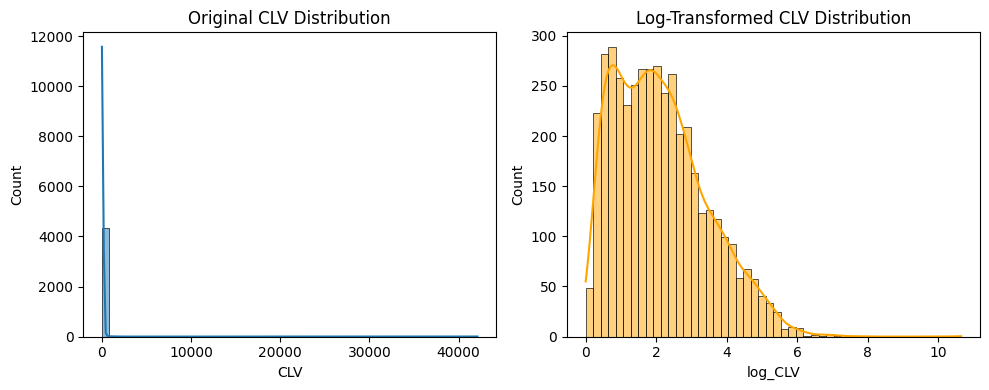

KeplerMapper(verbose=1)
Mapping on data shaped (4339, 3) using lens shaped (4339, 2)

Creating 144 hypercubes.

Created 56 edges and 24 nodes in 0:00:00.295105.
Mapper graph created with 24 nodes.
Wrote visualization to: clv_mapper_graph.html
Saved: clv_mapper_graph.html

Cluster-Level Business Summary:
Cluster 0 — Size: 1298, Avg Recency: 208.6, Avg Frequency: 1.8, Avg Monetary: 346.52
Cluster 1 — Size: 1989, Avg Recency: 127.3, Avg Frequency: 2.4, Avg Monetary: 671.77
Cluster 2 — Size: 1815, Avg Recency: 52.1, Avg Frequency: 3.4, Avg Monetary: 1163.74
Cluster 3 — Size: 1256, Avg Recency: 24.9, Avg Frequency: 4.7, Avg Monetary: 1831.87
Cluster 4 — Size: 665, Avg Recency: 11.5, Avg Frequency: 5.9, Avg Monetary: 2601.23
Cluster 5 — Size: 296, Avg Recency: 4.8, Avg Frequency: 6.4, Avg Monetary: 3048.11
Cluster 6 — Size: 65, Avg Recency: 2.5, Avg Frequency: 6.3, Avg Monetary: 3584.60
Cluster 7 — Size: 41, Avg Recency: 74.5, Avg Frequency: 5.7, Avg Monetary: 780.70
Cluster 8 — Size: 388, A

In [ ]:
# CUSTOMER SEGMENTATION USING MAPPER WITH CLV-PCA LENS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import DBSCAN

#Compute CLV and log(CL‌V)

def compute_clv_features(filepath):
    df = pd.read_excel(filepath)
    df = df[df['Quantity'] > 0]
    df = df[df['InvoiceNo'].astype(str).str[0] != 'C']
    df = df.dropna(subset=['CustomerID'])
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    snapshot = df['InvoiceDate'].max() + pd.Timedelta(days=1)

    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'TotalPrice': 'Monetary'
    })

    # Compute CLV and apply log transform to fix skew
    rfm['CLV'] = (rfm['Monetary'] / rfm['Frequency']) * (1 / (rfm['Recency'] + 1))
    rfm['log_CLV'] = np.log1p(rfm['CLV'])

    return rfm

#Plotting CLV and log(CL‌V)

def plot_clv_distribution(rfm):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(rfm['CLV'], bins=50, kde=True)
    plt.title("Original CLV Distribution")
    plt.subplot(1, 2, 2)
    sns.histplot(rfm['log_CLV'], bins=50, kde=True, color='orange')
    plt.title("Log-Transformed CLV Distribution")
    plt.tight_layout()
    plt.show()

#Apply Mapper with log(CL‌V)+PCA Lens

def apply_mapper_combined_lens(rfm):
    scaler = StandardScaler()
    X = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

    # Lens = PCA component + log(CL‌V)
    pca = PCA(n_components=1)
    pca_component = pca.fit_transform(X)
    lens = np.column_stack([pca_component, rfm['log_CLV'].values.reshape(-1, 1)])

    mapper = km.KeplerMapper(verbose=1)
    graph = mapper.map(
        lens,
        X,
        cover=km.Cover(n_cubes=12, perc_overlap=0.45),
        clusterer=DBSCAN(eps=0.4, min_samples=5)
    )

    return mapper, graph, X

#Visualizing Mapper Graph

def visualize_graph(mapper, graph, rfm):
    custom_tooltips = np.array(rfm.index.astype(str))
    mapper.visualize(
        graph,
        path_html="clv_mapper_graph.html",
        title="Mapper Graph with log(CL‌V) + PCA Lens",
        custom_tooltips=custom_tooltips
    )
    print("Saved: clv_mapper_graph.html")

#Printing Business Stats per Cluster

def print_cluster_summary(graph, rfm):
    print("\nCluster-Level Business Summary:")
    for i, node in enumerate(graph['nodes'].values()):
        segment = rfm.iloc[list(node)]
        print(f"Cluster {i} — Size: {len(segment)}, "
              f"Avg Recency: {segment['Recency'].mean():.1f}, "
              f"Avg Frequency: {segment['Frequency'].mean():.1f}, "
              f"Avg Monetary: {segment['Monetary'].mean():.2f}")

if __name__ == "__main__":
    filepath = "Online Retail.xlsx"
    rfm = compute_clv_features(filepath)
    print("CLV features computed.")

    plot_clv_distribution(rfm)

    mapper, graph, X = apply_mapper_combined_lens(rfm)
    print(f"Mapper graph created with {len(graph['nodes'])} nodes.")

    visualize_graph(mapper, graph, rfm)
    print_cluster_summary(graph, rfm)


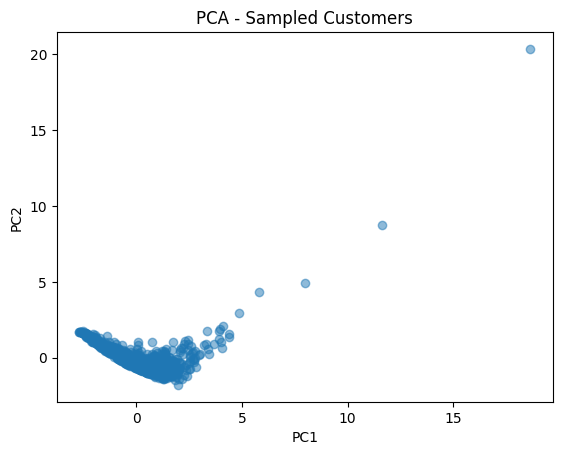

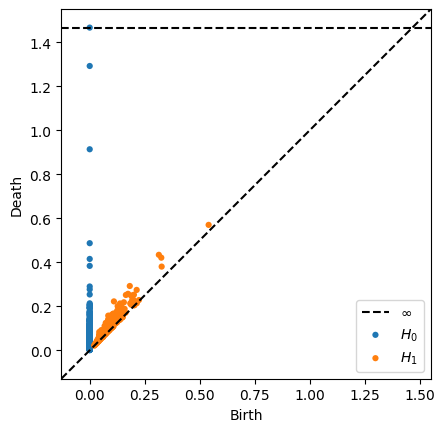

In [ ]:
#VISUALIZING PERSISTENT HOMOLOGY FOR E-COMMERCE CUSTOMER DATA

import pandas as pd
import numpy as np

df = pd.read_excel('Online Retail.xlsx')

# Data cleaning
df = df[df['Quantity'] > 0]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df.dropna(subset=['CustomerID'])

# RFM and CLV
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
snapshot = pd.to_datetime(df['InvoiceDate']).max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot - pd.to_datetime(x).max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})
rfm['CLV'] = (rfm['Monetary'] / rfm['Frequency']) * (1/(rfm['Recency'] + 1))
rfm['log_CLV'] = np.log1p(rfm['CLV'])

# Sampling a smaller subset due to technical constraints like GPU unavailability (e.g., 1000 customers)
rfm_sample = rfm.sample(n=1000, random_state=42)

from sklearn.preprocessing import StandardScaler
X = rfm_sample[['Recency', 'Frequency', 'Monetary', 'log_CLV']]
X_scaled = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA - Sampled Customers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

from ripser import ripser
from persim import plot_diagrams

X_2d = X_scaled[:, [0, 3]]  # e.g., Recency and log_CLV

result = ripser(X_2d, maxdim=1)
plot_diagrams(result['dgms'], show=True)

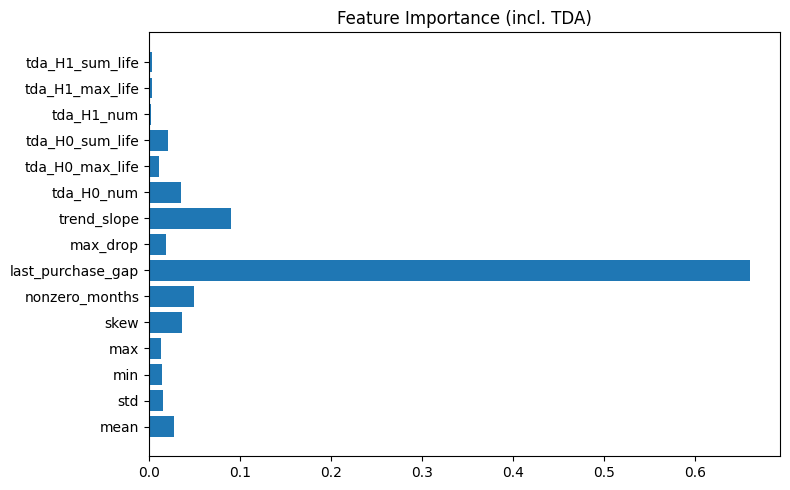

In [ ]:
# Feature Importance Analysis Using Classical and Topological Data Analysis

import pandas as pd
import numpy as np
from ripser import ripser
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
import matplotlib.pyplot as plt

#Load and preprocess data
df = pd.read_excel('Online Retail.xlsx', parse_dates=['InvoiceDate'])
if 'TotalPrice' not in df.columns:
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
customer_monthly = df.groupby(['CustomerID', 'InvoiceMonth'])['TotalPrice'].sum().reset_index()
pivot = customer_monthly.pivot(index='CustomerID', columns='InvoiceMonth', values='TotalPrice').fillna(0)

#Limit to last N months for all customers
N_MONTHS = 8
pivot = pivot.loc[:, pivot.columns.sort_values()[-N_MONTHS:]]

#Classical time series features
def extract_features(ts):
    features = {}
    features['mean'] = np.mean(ts)
    features['std'] = np.std(ts)
    features['min'] = np.min(ts)
    features['max'] = np.max(ts)
    features['skew'] = skew(ts)
    features['nonzero_months'] = np.count_nonzero(ts)
    features['last_purchase_gap'] = 0 if ts[-1] > 0 else len(ts) - np.max(np.where(ts > 0)[0]) if np.any(ts > 0) else len(ts)
    features['max_drop'] = np.max(np.diff(ts)) if len(ts) > 1 else 0
    # Linear trend (slope)
    X = np.arange(len(ts)).reshape(-1, 1)
    y = ts
    reg = LinearRegression().fit(X, y)
    features['trend_slope'] = reg.coef_[0]
    return features

classic_features = pd.DataFrame([extract_features(row) for row in pivot.values], index=pivot.index)

#TDA features for each customer
def delay_embed(ts, dim=2, tau=1):
    if len(ts) < (dim - 1) * tau + 1:
        return np.empty((0, dim))
    return np.column_stack([ts[i:len(ts)-(dim-1)*tau+i] for i in range(0, dim*tau, tau)])

def tda_summary(ts):
    emb = delay_embed(ts, dim=2, tau=1)
    if emb.shape[0] == 0:
        return {
            'tda_H0_num': 0,
            'tda_H0_max_life': 0,
            'tda_H0_sum_life': 0,
            'tda_H1_num': 0,
            'tda_H1_max_life': 0,
            'tda_H1_sum_life': 0,
        }
    dgms = ripser(emb, maxdim=1)['dgms']
    # H0
    h0 = dgms[0]
    h0_life = h0[:,1] - h0[:,0]
    h0_finite = h0[np.isfinite(h0).all(axis=1)]
    h0_life_finite = h0_finite[:,1] - h0_finite[:,0] if h0_finite.shape[0] > 0 else np.array([0])
    # H1
    h1 = dgms[1]
    h1_finite = h1[np.isfinite(h1).all(axis=1)]
    h1_life_finite = h1_finite[:,1] - h1_finite[:,0] if h1_finite.shape[0] > 0 else np.array([0])
    return {
        'tda_H0_num': len(h0_finite),
        'tda_H0_max_life': np.max(h0_life_finite) if len(h0_life_finite) > 0 else 0,
        'tda_H0_sum_life': np.sum(h0_life_finite) if len(h0_life_finite) > 0 else 0,
        'tda_H1_num': len(h1_finite),
        'tda_H1_max_life': np.max(h1_life_finite) if len(h1_life_finite) > 0 else 0,
        'tda_H1_sum_life': np.sum(h1_life_finite) if len(h1_life_finite) > 0 else 0,
    }

tda_features = pd.DataFrame([tda_summary(row) for row in pivot.values], index=pivot.index)

#Combine features and target
X_features = pd.concat([classic_features, tda_features], axis=1)
y = (pivot.iloc[:, -1] > 0).astype(int)  # Predict: did customer purchase in last month?

#Train/test split and modeling
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Feature importance plot
importances = clf.feature_importances_
feat_names = X_features.columns
plt.figure(figsize=(8,5))
plt.barh(feat_names, importances)
plt.title('Feature Importance (incl. TDA)')
plt.tight_layout()
plt.show()